# Week 13 — Bring it all together
## Loading and cleaning the data
Importing necessary libraries

In [1]:
# pip install dask[complete]

import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from joblib import Parallel, delayed
from lime.lime_tabular import LimeTabularExplainer
import lime
import lime.lime_tabular
import random

Since the dataset is too large to be loaded at once, we will be use the chunksize function in pandas to initially explore the dataset

In [2]:
chunk_size = 100000
chunks = pd.read_csv('train_ver2.csv', chunksize = chunk_size)
first_chunk = next(chunks)

pd.set_option('display.max_columns', None)

first_chunk.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


The above output allows us to identify how the columns are organized and some examples of the cells we will see in the dataset. With this, we can start working on the data types for each column

In [3]:
col = ['fecha_dato']
dates = pd.read_csv('train_ver2.csv', usecols=col)
dates['fecha_dato'] = pd.to_datetime(dates['fecha_dato'], errors='coerce')

old = dates.min()
new = dates.max()

print(f'First date = {old} \n Last date = {new}')

First date = fecha_dato   2015-01-28
dtype: datetime64[ns] 
 Last date = fecha_dato   2016-05-28
dtype: datetime64[ns]


In [4]:
monthly_count = dates.groupby([dates['fecha_dato'].dt.year, dates['fecha_dato'].dt.month]).size()
monthly_count

fecha_dato  fecha_dato
2015        1             625457
            2             627394
            3             629209
            4             630367
            5             631957
            6             632110
            7             829817
            8             843201
            9             865440
            10            892251
            11            906109
            12            912021
2016        1             916269
            2             920904
            3             925076
            4             928274
            5             931453
dtype: int64

Since the full dataset is over 2BG, we can't upload it in Jupyter, hence here we are exploring the dates range to determine where it will be our cuttoff. 
The data seems to be well distributed along the months so our cuttoff will be on June of 2016 and our final train dataset will have one year worth of records 

Since the dataset is too large to ingest at once, we will use Dask dataframes to process the initial changes. Dask handles datasets larger than the available memory by partitioning the data and processing it in parallel across multiple processors or machines -it works like a pandas dataframe, but with parallel processing

We will export the data as objects so we don't get any dtypes errors for now

In [5]:
data = dd.read_csv('train_ver2.csv', assume_missing=True, dtype=object)

In [6]:
data['fecha_dato'] = dd.to_datetime(data['fecha_dato'], errors='coerce')

cutoff = pd.Timestamp('2015-06-01')

filtered_data = data[data['fecha_dato'] >= cutoff]

rename_col = {
    'fecha_dato': 'date',
    'ncodpers': 'customer_code',
    'ind_empleado': 'employee_index',
    'pais_residencia': 'country',
    'sexo': 'sex_H',
    'age': 'age',
    'fecha_alta': 'first_contract_date',
    'ind_nuevo': 'new_cust',
    'antiguedad': 'seniority_in_months',
    'indrel': 'primary_cust',
    'ult_fec_cli_1t': 'last_date_primary',
    'indrel_1mes': 'cust_type',
    'tiprel_1mes': 'cust_relationship',
    'indresi': 'residency_spain',
    'indext': 'birth_spain',
    'conyuemp': 'employee_spouse',
    'canal_entrada': 'join_channel',
    'indfall': 'deceased',
    'tipodom': 'address_type',
    'cod_prov': 'province_code',
    'nomprov': 'province_name',
    'ind_actividad_cliente': 'active_cust',
    'renta': 'income',
    'segmento': 'segment',
    'ind_ahor_fin_ult1': 'savings_acct',
    'ind_aval_fin_ult1': 'guarantees',
    'ind_cco_fin_ult1': 'current_acct',
    'ind_cder_fin_ult1': 'derivada_acct',
    'ind_cno_fin_ult1': 'payroll_acct',
    'ind_ctju_fin_ult1': 'junior_acct',
    'ind_ctma_fin_ult1': 'mas_particular_acct',
    'ind_ctop_fin_ult1': 'particular_acct',
    'ind_ctpp_fin_ult1': 'particular_plus_acct',
    'ind_deco_fin_ult1': 'short_term_depo',
    'ind_deme_fin_ult1': 'medium_term_depo',
    'ind_dela_fin_ult1': 'long_term_depo',
    'ind_ecue_fin_ult1': 'e_acct',
    'ind_fond_fin_ult1': 'funds',
    'ind_hip_fin_ult1': 'mortgage',
    'ind_plan_fin_ult1': 'pension',
    'ind_pres_fin_ult1': 'loans',
    'ind_reca_fin_ult1': 'taxes',
    'ind_tjcr_fin_ult1': 'credit_card',
    'ind_valo_fin_ult1': 'securities',
    'ind_viv_fin_ult1': 'home_acct',
    'ind_nomina_ult1': 'payroll_acct_1',
    'ind_nom_pens_ult1': 'pensions_2',
    'ind_recibo_ult1': 'direct_debt'
}

filtered_data = filtered_data.rename(columns=rename_col)

Here we are filtering out the early months of the dataset and changing to columns name from Spanish to English for best comprehension.

We then call compute(). Since dask uses a parallel processing, it performs what is called lazy operation, meaning that the changes are not applied to the whole dataset unless it is forced -by using compute(). We want to force it here so we can start seeing null values and other important characteristics of the dataset to strat the cleaning process, which is what we are doing on the next code by seeing what kind of values are on each column and how many null values each column has.

In [7]:
filtered_data = filtered_data.drop(['province_code', 'address_type', 'employee_spouse'], axis=1)

After analyzing the previous output, we can see that the address_type column has only one value across the whole database, which is '1' (and null), so the column will be irrelevant to any future modeling. The column province_code has the same information as province_name, so we will drop the code one and keep the names. Lastly, the column employee_spouse has too many null values -over 10M, so we will drop it because it does not make sense to fill in those values since it is most of the database

In [8]:
filtered_data = filtered_data.loc[filtered_data['sex_H'].notnull()]

other = ['join_channel', 'province_name']
filtered_data[other] = filtered_data[other].fillna('other')

filtered_data['sex_H'] = filtered_data['sex_H'].map({'H': 1, 'V': 0}).fillna(0)

columns_to_dummy = ['residency_spain', 'birth_spain', 'deceased']
for col in columns_to_dummy:
    filtered_data[col] = filtered_data[col].map({'S': 1, 'N': 0}).fillna(0)

trim = ['customer_code', 'age', 'new_cust', 'seniority_in_months', 'primary_cust']
for col in trim:
    filtered_data[col] = filtered_data[col].astype(str).str.strip()   

c:\Users\MARIA\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask_expr\_collection.py:4192: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('sex_H', 'float64'))

  warnings.warn(meta_warning(meta))
c:\Users\MARIA\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask_expr\_collection.py:4192: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)

Above we are starting the cleaning process of the dataset. First we dropped the null values on the sex columns. We see the number 1861 repeating a lot across columns, so we will drop the null in sex and check if the other nulls will be drop. Since those nulls are across many columns, we concluded it would be best to drop them.

We filled null in columns join_channel and province_name with 'other' since they are string variables

We transformed the columns sex, residency_spain, birth_spain and deceased to dummy variables and filled na with 0

Lastly, we trimmed the cells on columns customer_code, age, new_cust, seniority_in_months, and primary_cust for cleanliness

In [9]:
products = ['savings_acct', 'guarantees', 'current_acct', 'derivada_acct', 'payroll_acct', 
            'junior_acct', 'mas_particular_acct', 'particular_acct', 'particular_plus_acct', 
            'short_term_depo', 'medium_term_depo', 'long_term_depo', 'e_acct', 'funds', 
            'mortgage', 'pension', 'loans', 'taxes', 'credit_card', 'securities', 
            'home_acct', 'payroll_acct_1', 'pensions_2', 'direct_debt']

filtered_data = filtered_data.fillna('0')


For now we will fill the rest of na values with '0' so we can keep cleaning the data. Later we will go back to these values and determine if the best approach is to fill it with '0'

In [10]:
dtype_mapping = {
    'customer_code': 'int',
    'employee_index': 'str',
    'country': 'str',
    'sex_H': 'str',
    'age': 'int',
    'first_contract_date': 'datetime64[ns]',
    'new_cust': 'int',
    'seniority_in_months': 'int',
    'primary_cust': 'int',
    'last_date_primary': 'object',
    'cust_type': 'object',
    'cust_relationship': 'str',
    'residency_spain': 'str',
    'birth_spain': 'str',
    'join_channel': 'str',
    'deceased': 'str',
    'province_name': 'str',
    'active_cust': 'int',
    'income': 'float',
    'segment': 'object',
    'savings_acct': 'int',
    'guarantees': 'int',
    'current_acct': 'int',
    'derivada_acct': 'int',
    'payroll_acct': 'int',
    'junior_acct': 'int',
    'mas_particular_acct': 'int',
    'particular_acct': 'int',
    'particular_plus_acct': 'int',
    'short_term_depo': 'int',
    'medium_term_depo': 'int',
    'long_term_depo': 'int',
    'e_acct': 'int',
    'funds': 'int',
    'mortgage': 'int',
    'pension': 'int',
    'loans': 'int',
    'taxes': 'int',
    'credit_card': 'int',
    'securities': 'int',
    'home_acct': 'int',
    'payroll_acct_1': 'int',
    'pensions_2': 'int',
    'direct_debt': 'int'
}
filtered_data = filtered_data.astype(dtype_mapping)

Now we will tranform the dtypes across the whole dataset and call compute() again to force all the above changes across the whole dataset

In [11]:
train = filtered_data.compute()

In [12]:
pd.set_option('display.max_columns', None)
train['total_products'] = train[products].sum(axis=1)

## NA values treatment

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10501007 entries, 27973 to 391600
Data columns (total 46 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   customer_code         int32         
 2   employee_index        object        
 3   country               object        
 4   sex_H                 object        
 5   age                   int32         
 6   first_contract_date   datetime64[ns]
 7   new_cust              int32         
 8   seniority_in_months   int32         
 9   primary_cust          int32         
 10  last_date_primary     object        
 11  cust_type             object        
 12  cust_relationship     object        
 13  residency_spain       object        
 14  birth_spain           object        
 15  join_channel          object        
 16  deceased              object        
 17  province_name         object        
 18  active_cust           int32         
 19  i

In [14]:
#Changing dates columns to datetime type

dates = ['date', 'first_contract_date']
train[dates] = train[dates].apply(pd.to_datetime)

In [15]:
pd.set_option('display.max_rows', None)

count_col = ['primary_cust', 'last_date_primary', 'deceased', 'seniority_in_months', 'province_name']

for col in count_col:
    count = train[col].value_counts()
    percentage = (count/count.sum()*100).round(2)
    products_bought = train.groupby(col)['total_products'].sum()
    summary = pd.DataFrame({'Count': count, 'Percentage':percentage, 'Products Owned': products_bought})
    print(summary)

                 Count  Percentage  Products Owned
primary_cust                                      
1             10480153        99.8        14363454
99               20854         0.2            1793
                      Count  Percentage  Products Owned
last_date_primary                                      
0                  10480153       99.80        14363454
2015-07-01              142        0.00              39
2015-07-02               63        0.00              17
2015-07-03               95        0.00              35
2015-07-06              138        0.00              38
2015-07-07              112        0.00              56
2015-07-08               65        0.00              27
2015-07-09              148        0.00              44
2015-07-10              117        0.00              58
2015-07-13               81        0.00              35
2015-07-14               72        0.00              28
2015-07-15               91        0.00              47
2015-07-16  

**Analyzing columns: Last Date Primary and Primary Customer**

In [16]:
print(train['last_date_primary'].value_counts())
print(train['primary_cust'].value_counts())

last_date_primary
0             10480153
2015-12-24         763
2015-12-28         521
2015-12-21         206
2015-12-17         172
2016-01-19         169
2016-01-05         167
2015-12-16         158
2015-07-09         148
2015-07-01         142
2015-12-18         139
2015-07-06         138
2016-04-01         132
2015-10-26         131
2015-07-21         130
2016-02-15         129
2015-10-05         129
2016-05-02         128
2015-11-02         128
2016-05-26         128
2015-10-28         125
2016-05-24         124
2016-01-13         122
2016-02-01         121
2015-07-10         117
2015-10-01         115
2015-07-28         115
2015-09-14         114
2015-10-15         113
2016-01-27         112
2015-07-07         112
2015-10-07         112
2016-05-19         111
2015-09-18         111
2015-07-17         111
2016-01-22         111
2015-11-18         110
2015-07-20         110
2015-10-19         110
2015-11-16         109
2015-11-24         109
2016-01-26         109
2016-05-27      

In [17]:
non_primary = train[train['primary_cust'] == 99]
non_primary['total_products'].sum()

1793

0 dates on last_date_primary mean they are still primary customers  
We will drop the column primary customer and keep the last date as primary customer since we can have all the information from one column -customers that do not have a date are still primary  
We will keep the non-primary customers since they still own products of the bank  
  
**Analyzing column: Deceased**

In [18]:
train.groupby('deceased')[products].sum()

,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,mas_particular_acct,particular_acct,particular_plus_acct,short_term_depo,medium_term_depo,long_term_depo,e_acct,funds,mortgage,pension,loans,taxes,credit_card,securities,home_acct,payroll_acct_1,pensions_2,direct_debt
deceased,,,,,,,,,,,,,,,,,,,,,,,,
0,958,214,6488365,3821,797691,90875,93534,1224073,410541,13755,14864,408996,818287,178694,55297,87879,23989,518765,428935,247980,36493,539367,588624,1262545
1,0,0,12798,12,594,0,106,8225,1236,42,40,831,1211,1042,257,318,147,1443,27,1120,41,59,159,997


Deceased clients have a few products, and they make up 0.2% of the database. Deceased clients are not going to buy any more products, so we will drop the rows of deceased clients and drop the column  

**Analyzing column: Seniority in Months**  
We will drop the rows with value -999999

**Analyzing column: Province Name**  
We will drop the rows where province name = others

**Analyzing column: Age**  
We will drop columns where age is 0 and over 100. We believe these clients are not going to be valuable on our model  

**Analyzing column: Income**

In [19]:
(train['income'] == 0).sum()

2238903

**Analyzing columns: Seniority in Months and First Contract Date**  
We had the impression these two columns were giving us the same information and we decided to check the correlation. Turns out it is highly correlated, so we'll keep the column seniority in months.  
Before we delete the first contract date column, we want to extract any information we might need from it.

In [20]:
correlation = train[['seniority_in_months', 'first_contract_date']].corr()
print(correlation)

                     seniority_in_months  first_contract_date
seniority_in_months              1.00000             -0.03798
first_contract_date             -0.03798              1.00000


Text(0, 0.5, 'Count in millions')

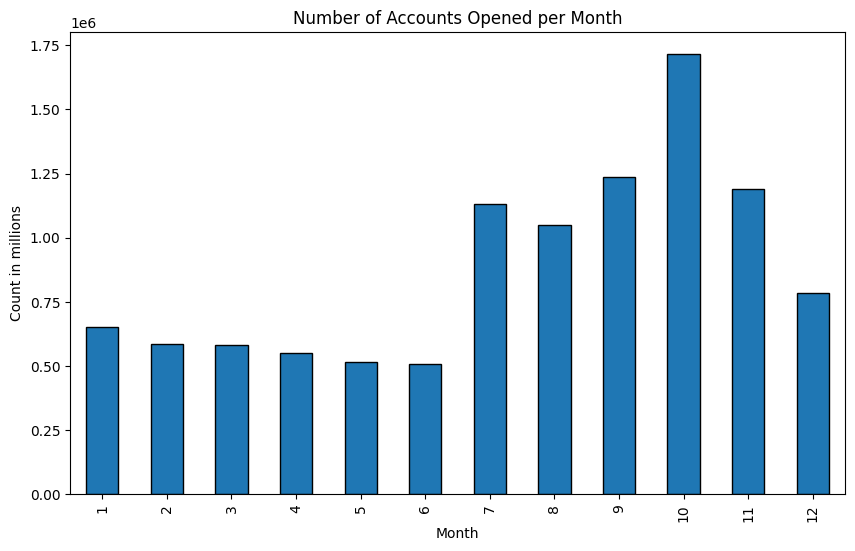

In [21]:
month_count = train['first_contract_date'].dt.month.value_counts().sort_index()

month_count.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title('Number of Accounts Opened per Month')
plt.xlabel('Month')
plt.ylabel('Count in millions')

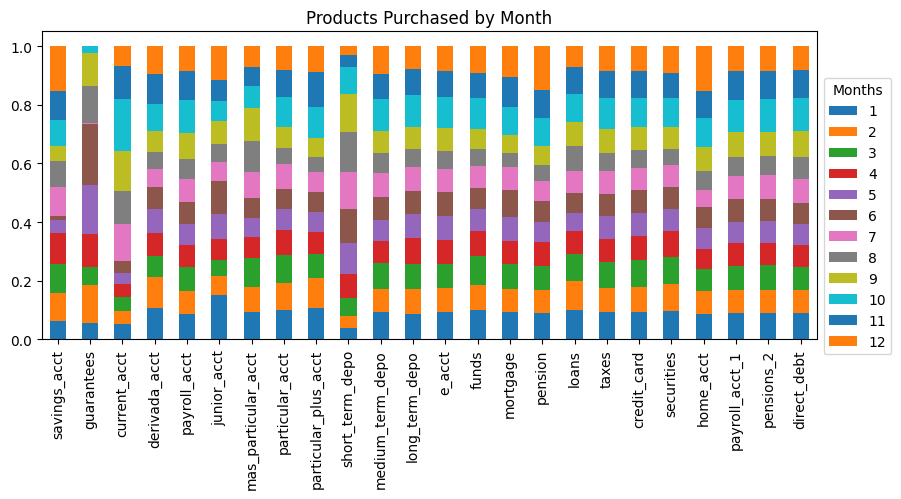

In [22]:
months = train['first_contract_date'].dt.month
dummy = train.groupby(months)[products].sum()
dummy = (dummy/dummy.sum()).T
ax = dummy.plot(kind='bar', stacked=True, figsize=(10,4))
plt.legend(loc='center left', title='Months', bbox_to_anchor=(1, .4))
plt.title('Products Purchased by Month')
plt.show()

When we plot contract dates by month to see if there is any seasonality, we can conclude that the last half of the year has significantly more new contracts than the first half. This can maybe be explained by raises, bonus, new people getting hired after summer, and other factors  
We don't see any patterns on product purchases for a specific month. Looks like the increase on purchases in the second half of the year is an overall increase 

## Splitting the dataset into train and validation
We will use the 80/20 ratio

In [23]:
train, temp = train_test_split(train, test_size=0.3, random_state=42)

val_set, test_set = train_test_split(temp, test_size=0.5, random_state=42)

In [24]:
map_dtypes = {
    "date": "datetime64[ns]",
    "customer_code": "int32",
    "employee_index": "object",
    "country": "object",
    "sex_H": "object",
    "age": "int32",
    "first_contract_date": "datetime64[ns]",
    "new_cust": "int32",
    "seniority_in_months": "int32",
    "primary_cust": "int32",
    "last_date_primary": "object",
    "cust_type": "object",
    "cust_relationship": "object",
    "residency_spain": "object",
    "birth_spain": "object",
    "join_channel": "object",
    "deceased": "object",
    "province_name": "object",
    "active_cust": "int32",
    "income": "float64",
    "segment": "object",
    "savings_acct": "int32",
    "guarantees": "int32",
    "current_acct": "int32",
    "derivada_acct": "int32",
    "payroll_acct": "int32",
    "junior_acct": "int32",
    "mas_particular_acct": "int32",
    "particular_acct": "int32",
    "particular_plus_acct": "int32",
    "short_term_depo": "int32",
    "medium_term_depo": "int32",
    "long_term_depo": "int32",
    "e_acct": "int32",
    "funds": "int32",
    "mortgage": "int32",
    "pension": "int32",
    "loans": "int32",
    "taxes": "int32",
    "credit_card": "int32",
    "securities": "int32",
    "home_acct": "int32",
    "payroll_acct_1": "int32",
    "pensions_2": "int32",
    "direct_debt": "int32",
    "total_products": "int64"
}

test_set = test_set.astype(map_dtypes)
val_set = val_set.astype(map_dtypes)